In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Linear, BatchNorm2d, Dropout2d
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
class GRSDataset(Dataset):
    def __init__(self, dataframe, frame_dir, transform=None, sequence_length=16):
        self.data = dataframe.copy()
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        video_id = row["VIDEO"]
        label = int(row["GRS"])
        path = self.frame_dir / video_id

        frames = sorted(path.glob("*.jpg"))
        selected = frames[:self.sequence_length]
        if len(selected) == 0:
            raise IndexError(f"No frames found for video {video_id}")
        while len(selected) < self.sequence_length:
            selected.append(selected[-1])

        images = [self.transform(Image.open(f).convert("RGB")) for f in selected]
        return torch.stack(images), label


In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

LABEL_PATH = Path("../data/labels/labels_task1.csv")
FRAME_DIR = Path("../data/frames")

df = pd.read_csv(LABEL_PATH)
available_videos = {p.name for p in FRAME_DIR.iterdir() if p.is_dir() and any(p.glob("*.jpg"))}
df = df[df["VIDEO"].isin(available_videos)].reset_index(drop=True)

dataset = GRSDataset(df, FRAME_DIR, transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.block1 = self._create_block(64, 64, 1)
        self.block2 = self._create_block(64, 128, 2)
        self.block3 = self._create_block(128, 256, 2)
        self.block4 = self._create_block(256, 512, 2)
        self.linear = nn.Linear(512, num_classes)

    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        out = ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = nn.AvgPool2d(4)(out)
        out = out.view(B, T, -1).mean(dim=1)  # média temporal dos frames

        out = self.linear(out)
        return out

In [5]:
class CNNModel_1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, 3),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.layer2 = Sequential(
            Conv2d(32, 32, 3),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.fc1 = Linear(32*6*6, 100)  # para 32x32 input após convoluções e pools
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(100, 4)
        xavier_uniform_(self.fc2.weight)
        self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        return out


In [6]:
class CNNModel_2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 16, 3),
            ReLU(),
            MaxPool2d(2)
        )
        self.layer2 = Sequential(
            Conv2d(16, 32, 3),
            ReLU(),
            MaxPool2d(2)
        )
        self.fc1 = Linear(32*6*6, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        return out


In [7]:
class CNNModel_3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(
            Conv2d(3, 32, 3, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            Conv2d(32, 64, 3),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(2)
        )
        self.fc1 = Linear(64*7*7, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(600, 120)
        self.fc3 = Linear(120, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [8]:
class CNNModel_4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, 5),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2),
            Dropout2d(0.2)
        )
        self.fc1 = Linear(32*14*14, 128)
        self.fc2 = Linear(128, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [9]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super(CNNLSTMClassifier, self).__init__()

        # Carregar ResNet18 pré-treinada e remover a fully connected
        base_cnn = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_cnn.children())[:-1])  # até ao penúltimo bloco
        self.feature_dim = base_cnn.fc.in_features  # normalmente 512

        # LSTM para modelar a sequência de features
        self.lstm = nn.LSTM(input_size=self.feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)

        # Camada final para classificação
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)

        # Congelar CNN inicialmente (opcional)
        with torch.no_grad():
            features = self.feature_extractor(x).view(batch_size, seq_len, -1)

        lstm_out, _ = self.lstm(features)
        last_hidden = lstm_out[:, -1, :]
        out = self.classifier(last_hidden)
        return out


In [10]:
from torchvision import models

class EfficientNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super(EfficientNetLSTM, self).__init__()

        base = models.efficientnet_b0(pretrained=True)
        self.feature_extractor = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.feature_dim = 1280  # saída de efficientnet_b0

        self.lstm = nn.LSTM(input_size=self.feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)
        with torch.no_grad():
            features = self.pool(self.feature_extractor(x)).view(batch_size, seq_len, -1)

        out, _ = self.lstm(features)
        last = out[:, -1, :]
        return self.classifier(last)


In [11]:
from timm import create_model

class ViTTemporalAvg(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=4):
        super(ViTTemporalAvg, self).__init__()
        self.vit = create_model(model_name, pretrained=True)
        self.vit.head = nn.Identity()  # remover camada final
        self.feature_dim = self.vit.num_features

        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        with torch.no_grad():
            feats = self.vit(x).view(B, T, -1)

        avg_feats = feats.mean(dim=1)
        return self.classifier(avg_feats)

/home/luis/miniconda3/envs/ap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from pytorchvideo.models.hub import timesformer_base

class TimeSformerWrapper(nn.Module):
    def __init__(self, num_classes=4):
        super(TimeSformerWrapper, self).__init__()
        self.model = timesformer_base(pretrained=True)
        self.model.blocks[-1].drop_path_rate = 0.1
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

ImportError: cannot import name 'timesformer_base' from 'pytorchvideo.models.hub' (/home/luis/miniconda3/envs/ap/lib/python3.9/site-packages/pytorchvideo/models/hub/__init__.py)

In [ ]:
def train_model(model, dataloader, epochs=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")
        history.append((total_loss, acc))

    return history


In [ ]:
model = EfficientNetLSTM().to(device)
# Ou:
# model = ViTTemporalAvg().to(device)
# model = TimeSformerWrapper().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train_one_epoch(model, loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, loader, criterion)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")


In [ ]:
model1 = CNNModel_1()
hist1 = train_model(model1, loader, 100)

model2 = CNNModel_2()
hist2 = train_model(model2, loader, 100)

model3 = CNNModel_3()
hist3 = train_model(model3, loader, 100)

model4 = CNNModel_4()
hist4 = train_model(model4, loader, 100)


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]


Epoch 1, Loss: 11.1521, Accuracy: 0.2333


100%|██████████| 8/8 [00:00<00:00, 10.79it/s]


Epoch 2, Loss: 10.8698, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.56it/s]


Epoch 3, Loss: 10.8051, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.35it/s]


Epoch 4, Loss: 10.6591, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.46it/s]


Epoch 5, Loss: 10.5076, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.95it/s]


Epoch 6, Loss: 10.3183, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


Epoch 7, Loss: 10.2567, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.66it/s]


Epoch 8, Loss: 10.2739, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00, 10.40it/s]


Epoch 9, Loss: 10.2372, Accuracy: 0.4333


100%|██████████| 8/8 [00:01<00:00,  6.93it/s]


Epoch 10, Loss: 10.1395, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00, 10.41it/s]


Epoch 11, Loss: 10.0164, Accuracy: 0.4333


100%|██████████| 8/8 [00:00<00:00,  9.33it/s]


Epoch 12, Loss: 9.9624, Accuracy: 0.4667


100%|██████████| 8/8 [00:00<00:00, 10.69it/s]


Epoch 13, Loss: 9.7762, Accuracy: 0.5000


100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


Epoch 14, Loss: 9.8057, Accuracy: 0.5667


100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


Epoch 15, Loss: 9.5978, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  8.13it/s]


Epoch 16, Loss: 9.4780, Accuracy: 0.5667


100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Epoch 17, Loss: 9.3862, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


Epoch 18, Loss: 9.4050, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00, 10.39it/s]


Epoch 19, Loss: 9.1991, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  9.78it/s]


Epoch 20, Loss: 9.1924, Accuracy: 0.6000


100%|██████████| 8/8 [00:00<00:00,  9.20it/s]


Epoch 21, Loss: 8.9427, Accuracy: 0.6667


100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


Epoch 22, Loss: 9.1354, Accuracy: 0.6667


100%|██████████| 8/8 [00:01<00:00,  7.00it/s]


Epoch 23, Loss: 8.8746, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00, 11.57it/s]


Epoch 24, Loss: 8.8397, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


Epoch 25, Loss: 8.6739, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00,  9.94it/s]


Epoch 26, Loss: 8.7265, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  9.47it/s]


Epoch 27, Loss: 8.5813, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.75it/s]


Epoch 28, Loss: 8.4015, Accuracy: 0.7667


100%|██████████| 8/8 [00:00<00:00,  9.30it/s]


Epoch 29, Loss: 8.4953, Accuracy: 0.7000


100%|██████████| 8/8 [00:00<00:00, 10.76it/s]


Epoch 30, Loss: 8.4148, Accuracy: 0.7333


100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


Epoch 31, Loss: 8.1501, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  9.14it/s]


Epoch 32, Loss: 8.4710, Accuracy: 0.7667


100%|██████████| 8/8 [00:00<00:00,  8.96it/s]


Epoch 33, Loss: 8.1252, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


Epoch 34, Loss: 8.0278, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.53it/s]


Epoch 35, Loss: 8.0085, Accuracy: 0.8333


100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Epoch 36, Loss: 7.9278, Accuracy: 0.8000


100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


Epoch 37, Loss: 8.0537, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


Epoch 38, Loss: 8.0104, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Epoch 39, Loss: 7.9852, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


Epoch 40, Loss: 7.8633, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Epoch 41, Loss: 7.6124, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Epoch 42, Loss: 7.5295, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00, 10.79it/s]


Epoch 43, Loss: 7.5815, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.99it/s]


Epoch 44, Loss: 7.4907, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.24it/s]


Epoch 45, Loss: 7.4420, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.78it/s]


Epoch 46, Loss: 7.6358, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


Epoch 47, Loss: 7.3577, Accuracy: 0.8667


100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Epoch 48, Loss: 7.6047, Accuracy: 0.8667


 12%|█▎        | 1/8 [00:00<00:01,  6.33it/s]


KeyboardInterrupt: 

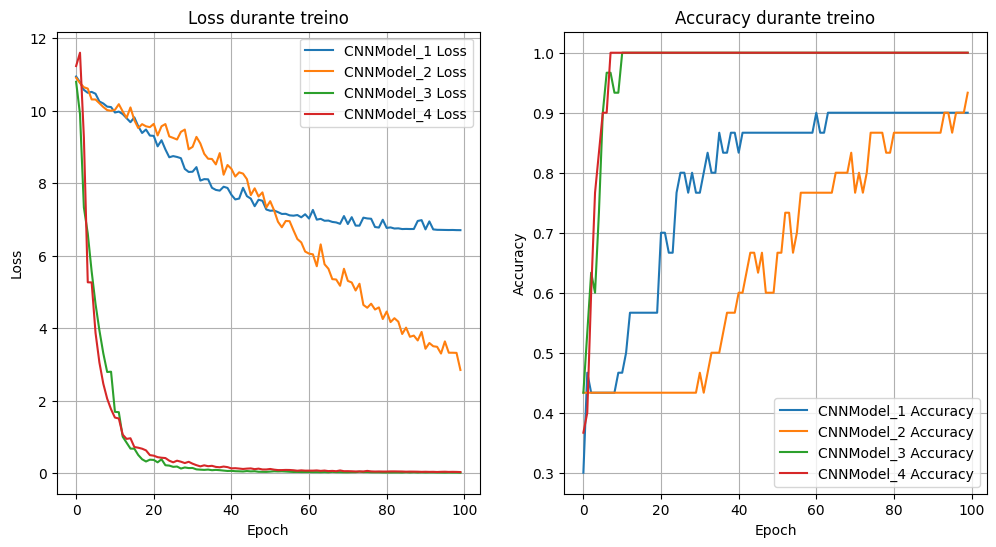

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot([h[0] for h in hist1], label='CNNModel_1 Loss')
plt.plot([h[0] for h in hist2], label='CNNModel_2 Loss')
plt.plot([h[0] for h in hist3], label='CNNModel_3 Loss')
plt.plot([h[0] for h in hist4], label='CNNModel_4 Loss')
plt.title('Loss durante treino')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot([h[1] for h in hist1], label='CNNModel_1 Accuracy')
plt.plot([h[1] for h in hist2], label='CNNModel_2 Accuracy')
plt.plot([h[1] for h in hist3], label='CNNModel_3 Accuracy')
plt.plot([h[1] for h in hist4], label='CNNModel_4 Accuracy')
plt.title('Accuracy durante treino')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()


In [ ]:
torch.save(model1.state_dict(), "../outputs/models/model_task1_grs_cnn1.pt")
print("Modelo salvo!")

Modelo salvo!
